# Arash Modaresi Rad

## student ID: 114089286

### Collaborate: Amir Kazemzadeh & Ahmad Hojatimalekshah

# CS534 Homework 2

Put your homework in the directory with your name. Please mentionin this file the names of any students with whom you collaborated. If you didn't collaborate with anyone, mark your collaborators as "None." Remember, your goal is to communicate. Full credit will be given only to correct solutions which are described clearly. Convoluted and obtuse descriptions will receive low marks. To complete your homework, you may ONLY consult the following material:

lecture slides
course notes you or others took during lecture.
the required text (CLRS)
websites that may clarify the concepts covered in the material but do not in any way provide complete solutions to the problems.
Deadline 3/4/2020

Please provide an answer to the following question: 

# Question 1 (15 pts)
Implement the fit and predict procedures for the logistic regression (scikit is not allowed) with norm 2 regularization function (and Lambda parameter).
Use as the imput parameters of the gradient ascent the maximum number of iterations (just a constant e.g 100) and the learning factor (e.g. 0.01).


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split , StratifiedKFold, KFold, cross_validate, learning_curve, GridSearchCV

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


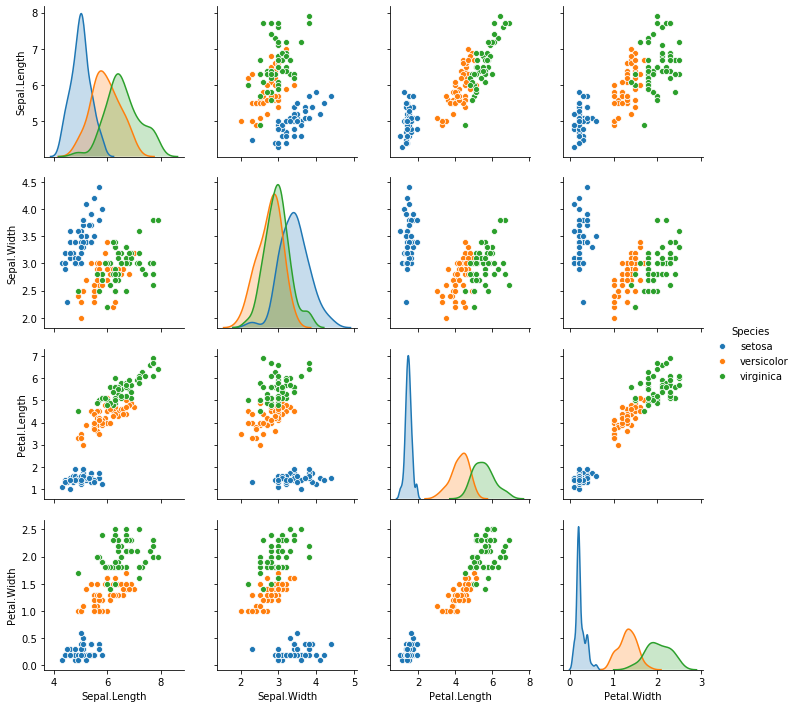

In [2]:
iris_d = sm.datasets.get_rdataset('iris')
iris = iris_d.data
sns.pairplot(data=iris, hue='Species')

Now lets see our target variable:

In [3]:
iris['Species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

lets make it a binery traget vatiable with versicolor = 1 and the rest being zero

In [4]:
iris['Species'] = iris['Species'].apply(lambda x: 1  if x == 'versicolor' else 0)
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


**now lets create our test and training samples**

In [5]:
test = iris.sample(frac=0.2)
test.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
50,7.0,3.2,4.7,1.4,1
93,5.0,2.3,3.3,1.0,1
8,4.4,2.9,1.4,0.2,0
88,5.6,3.0,4.1,1.3,1
104,6.5,3.0,5.8,2.2,0


In [6]:
train_mask = pd.Series(True, index=iris.index)
train_mask[test.index] = False
train = iris[train_mask]
train.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
train_X=train[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
train_Y=train['Species']
test_X=test[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
test_Y=test['Species']

**standardize the data**

In [8]:
StdS = StandardScaler()
StdS.fit(train_X)
train_X_std = pd.DataFrame(StdS.transform(train_X),columns={'Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'})
test_X_std = pd.DataFrame(StdS.transform(test_X),columns={'Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'})
train_X_std.head()

,Sepal.Width,Petal.Width,Petal.Length,Sepal.Length
0,-0.904902,0.946803,-1.292856,-1.253778
1,-1.168466,-0.187093,-1.292856,-1.253778
2,-1.432030,0.266465,-1.350745,-1.253778
3,-1.563812,0.039686,-1.234967,-1.253778
4,-1.036684,1.173582,-1.292856,-1.253778


let check if data are actually standardized:

In [9]:
train_X_std.describe()

,Sepal.Width,Petal.Width,Petal.Length,Sepal.Length
count,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
mean,-2.988350e-16,-1.142836e-15,7.308968e-17,2.775558e-17
std,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00
min,-1.959158e+00,-2.454884e+00,-1.466523e+00,-1.383256e+00
25%,-9.049024e-01,-6.406509e-01,-1.234967e+00,-1.124300e+00
50%,-1.142110e-01,-1.870927e-01,3.280380e-01,1.704793e-01
75%,8.082624e-01,7.200236e-01,8.490396e-01,8.178690e-01
max,2.784991e+00,2.987814e+00,1.775265e+00,1.724215e+00


**Implement Logistic Regression with l2 norm**

lets create a class of our nessesary functions:

In [10]:
class Functions:
    """This function returns function values as well as their derivatives"""
    
    def __init__(self):
        self.func_value = 0
    
    def sigmoid(self, Pval):
        sig = (1 / (1 + np.exp(-Pval)))
        return sig

    def predict_probability(self, features, weights):
        Pval = np.dot(features, weights) 
        PP = self.sigmoid(Pval)
        return PP

    def log_likelihood(self, features, label, weights):
        indicator = (label == +1)
        scores = np.dot(features, weights)
        ll = np.sum((np.transpose(np.array([indicator])) - 1) * scores - np.log(1. + np.exp(-scores)))
        return ll

    def derivative(self, errors, feature):
        derivative = np.dot(np.transpose(errors), feature)
        return derivative

    def l2_derivative(self, errors, feature, weight, l2_penalty, feature_is_constant):
        derivative = np.dot(np.transpose(errors), feature)
        if not feature_is_constant:
            derivative -= 2 * l2_penalty * weight
        return derivative

    def l2_log_likelihood(self, features, labels, weights, l2_penalty):
        indicator = (labels == +1)
        scores = np.dot(features, weights)
        ll = np.sum((np.transpose(np.array([indicator])) -1 ) * scores - np.log(1. + np.exp(-scores))) - (l2_penalty * np.sum(weights[1:] ** 2))
        return ll

     

now lets build a logistic regression with L2 regularization with gradient ascent

In [11]:
def l2_logistic_regression(features, labels, lr, max_itr, l2_penalty):
    
  # add bias (intercept) with features matrix
    bias      = np.ones((features.shape[0], 1))
    features  = np.hstack((bias, features))

  # initialize the weight coefficients
    weights = np.zeros((features.shape[1], 1))
    logs = []

  # loop over max_itr times
    for epoch in range(max_itr):
        # predict probability for each row in the dataset
        predictions = Functions().predict_probability(features, weights)

        # calculate the indicator value
        indicators = (labels == +1)

        # calculate the errors
        errors = np.transpose(np.array([indicators])) - predictions
        # loop over each weight coefficient
        for j in range(len(weights)):
            isIntercept = (j == 0)
            # calculate the derivative of jth weight cofficient for gradient ascent
            derivative = Functions().l2_derivative(errors, features[:,j], weights[j], l2_penalty, isIntercept)
            #update based on gradient ascent
            weights[j] += lr * derivative

        # compute the log-likelihood
        ll = Functions().l2_log_likelihood(features, labels, weights, l2_penalty)
        logs.append(ll)

    x = np.linspace(0, len(logs), len(logs))
    C = 1 / l2_penalty


    return {'weights': weights, 'X_value': x, 'LL': logs, 'C': C}

In [12]:
learning_rate = 1e-2
max_itr        = 100
l2_penalty    = 0.1
out1 = l2_logistic_regression(train_X_std, train_Y, learning_rate, max_itr, l2_penalty)
learning_rate = 1e-2
l2_penalty    = 1
out2 = l2_logistic_regression(train_X_std, train_Y, learning_rate, max_itr, l2_penalty)
learning_rate = 1e-2
l2_penalty    = 10
out3 = l2_logistic_regression(train_X_std, train_Y, learning_rate, max_itr, l2_penalty)
learning_rate = 1e-4
l2_penalty    = 100
out4 = l2_logistic_regression(train_X_std, train_Y, learning_rate, max_itr, l2_penalty)

**Results:**

intiate ploting

<Figure size 432x288 with 0 Axes>

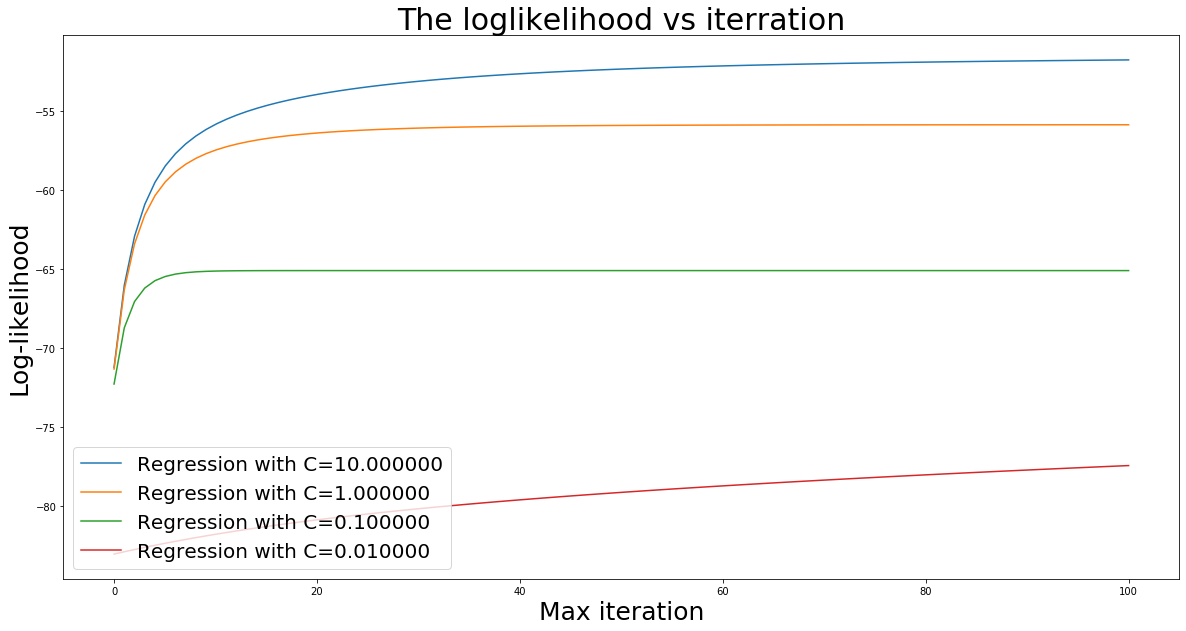

In [13]:
fig = plt.figure()
plt.figure(figsize=(20, 10))
line1, = plt.plot(out1['X_value'], out1['LL'])
line2, = plt.plot(out2['X_value'], out2['LL'])
line3, = plt.plot(out3['X_value'], out3['LL'])
line4, = plt.plot(out4['X_value'], out4['LL'])
plt.title('The loglikelihood vs iterration' ,fontsize = 30)
plt.xlabel('Max iteration', fontsize = 25)
plt.ylabel('Log-likelihood', fontsize = 25)
plt.legend([line1, line2, line3, line4], ['Regression with C=%f' %out1['C'], 'Regression with C=%f' %out2['C'], 'Regression with C=%f' %out3['C'], 'Regression with C=%f' %out4['C']], fontsize =20)
plt.show()

Setup confusion matrix and find the goodness of fit

In [14]:
bias_test = np.ones((test_X_std.shape[0], 1))
test_X_new = np.hstack((bias_test, test_X_std))
bias_train = np.ones((train_X_std.shape[0], 1))
train_X_new = np.hstack((bias_train, train_X_std))

train_predictions = (Functions().predict_probability(train_X_new, out4['weights']).flatten() > 0.5)
train_predictions = train_predictions.astype('int')
test_predictions  = (Functions().predict_probability(test_X_new, out4['weights']).flatten() > 0.5)
test_predictions = test_predictions.astype('int')

train['predicted'] = train_predictions
test['predicted'] = test_predictions

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


**training**

In [15]:
confusion_train = train.groupby(['Species', 'predicted'])['Sepal.Length'].count()
confusion_train.unstack()

predicted,0,1
Species,,
0,79,3
1,34,4


In [16]:
print('The Logistic regression accuracy for training data is: ',(confusion_train[0][0] + confusion_train[1][1]) / sum(confusion_train))

The Logistic regression accuracy for training data is:  0.6916666666666667


**testing**

In [17]:
confusion_test = test.groupby(['Species', 'predicted'])['Sepal.Length'].count()
confusion_test.unstack()

predicted,0,1
Species,,
0,15,3
1,10,2


In [18]:
print('The Logistic regression accuracy for training data is: ',(confusion_test[0][0] + confusion_test[1][1]) / sum(confusion_test))

The Logistic regression accuracy for training data is:  0.5666666666666667


# Question 2 (20 pts)
Use the iris dataset (just the binary class Iris Setosa vs others), the K-fold cross validation, metrics(accuracy, precision, recall, F1-score) and the logistic regression with L2 regularization.
You can use scikit.
Please estimate the best parameter C(the inverse of lambda) 



In [19]:
iris_d = sm.datasets.get_rdataset('iris')
iris = iris_d.data
iris['Species'] = iris['Species'].apply(lambda x: 1  if x == 'setosa' else 0)
test = iris.sample(frac=0.2)
train_mask = pd.Series(True, index=iris.index)
train_mask[test.index] = False
train = iris[train_mask]

train_X=train[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
train_Y=train['Species']
test_X=test[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']]
test_Y=test['Species']

StdS = StandardScaler()
StdS.fit(train_X)
train_X_std = pd.DataFrame(StdS.transform(train_X),columns={'Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'})
test_X_std = pd.DataFrame(StdS.transform(test_X),columns={'Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'})
train_X_std.head()

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


,Sepal.Width,Petal.Width,Petal.Length,Sepal.Length
0,-0.864959,0.964819,-1.321214,-1.317569
1,-1.112680,-0.163624,-1.321214,-1.317569
2,-1.360401,0.287753,-1.378265,-1.317569
3,-1.484261,0.062064,-1.264163,-1.317569
4,-0.988819,1.190508,-1.321214,-1.317569


In [20]:
import warnings
warnings.filterwarnings("ignore")
C = np.logspace(-10,10,20)
scoring = ['accuracy','precision', 'recall', 'f1']
Output_train = pd.DataFrame(columns = ['C_value', 'mean_accuracy','mean_Recall','mean_Precision','mean_F1_score'])
Output_test = pd.DataFrame(columns = ['C_value', 'mean_accuracy','mean_Recall','mean_Precision','mean_F1_score'])
i = 0
for c in C:
    kfold = model_selection.KFold(n_splits = 5, random_state = 4, shuffle=True)
    model=LogisticRegression(penalty = 'l2', C = c, solver = 'liblinear', fit_intercept = True)
    CV_results_train = cross_validate(estimator = model, X = train_X_std, y = train_Y, cv = kfold, scoring = scoring)
    Output_train.loc[i] = [c, CV_results_train['test_accuracy'].mean(), CV_results_train['test_precision'].mean(), CV_results_train['test_recall'].mean(), CV_results_train['test_f1'].mean()]
    CV_results_test = cross_validate(estimator = model, X = test_X_std, y = test_Y, cv = kfold, scoring = scoring)
    Output_test.loc[i] = [c, CV_results_test['test_accuracy'].mean(), CV_results_test['test_precision'].mean(), CV_results_test['test_recall'].mean(), CV_results_test['test_f1'].mean()]
    i += 1

**training results:**

In [21]:
Output_train

,C_value,mean_accuracy,mean_Recall,mean_Precision,mean_F1_score
0,1.000000e-10,0.983333,0.955556,1.0,0.975
1,1.128838e-09,0.983333,0.955556,1.0,0.975
2,1.274275e-08,0.983333,0.955556,1.0,0.975
3,1.438450e-07,0.983333,0.955556,1.0,0.975
4,1.623777e-06,0.983333,0.955556,1.0,0.975
5,1.832981e-05,0.983333,0.955556,1.0,0.975
6,2.069138e-04,1.000000,1.000000,1.0,1.000
7,2.335721e-03,1.000000,1.000000,1.0,1.000
8,2.636651e-02,1.000000,1.000000,1.0,1.000
9,2.976351e-01,1.000000,1.000000,1.0,1.000


**testing_result**

In [22]:
Output_test

,C_value,mean_accuracy,mean_Recall,mean_Precision,mean_F1_score
0,1.000000e-10,1.0,0.8,0.8,0.8
1,1.128838e-09,1.0,0.8,0.8,0.8
2,1.274275e-08,1.0,0.8,0.8,0.8
3,1.438450e-07,1.0,0.8,0.8,0.8
4,1.623777e-06,1.0,0.8,0.8,0.8
5,1.832981e-05,1.0,0.8,0.8,0.8
6,2.069138e-04,1.0,0.8,0.8,0.8
7,2.335721e-03,1.0,0.8,0.8,0.8
8,2.636651e-02,1.0,0.8,0.8,0.8
9,2.976351e-01,1.0,0.8,0.8,0.8


According to the table the best values of C according to the training datset are those that are after row number 6 and according to testing dataset is all of them, However for indepth search and more precise one we can use the gridsearch tool.

In [23]:
grid={"C":np.logspace(-10,10,2000), "penalty":["l1","l2"]}
logreg=LogisticRegression(fit_intercept=True)
logreg_cv=GridSearchCV(logreg, grid, cv=10)
logreg_cv.fit(train_X_std, train_Y)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.007480609224895012, 'penalty': 'l2'}
accuracy : 1.0


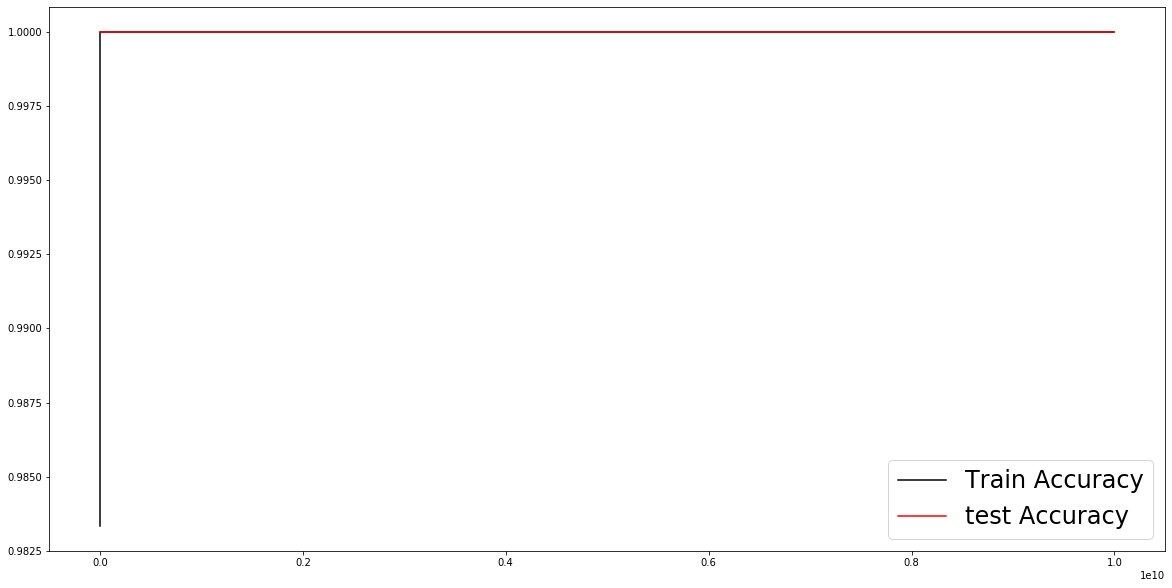

In [24]:
plt.figure(figsize=(20,10))
plt.plot(C, Output_train.groupby(['C_value'])['mean_accuracy'].mean(), 'k')
plt.plot(C, Output_test.groupby(['C_value'])['mean_accuracy'].mean(), 'r')
plt.legend(("Train Accuracy", "test Accuracy"),fontsize=24)